In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import pandas as pd 
import numpy as np
import seaborn as sns

We want to: 
1) regress IMV on midpoint error, trial and midpoint sensory uncertainty on the previous trial as well as the interaction between midpoint error and uncertainty on the previous trial. 
2) regress change in IMV (between trials) on midpoint error and midpoint sensory uncertainty on the previous trial as well as the interaction between midpoint error and uncertainty on the previous trial. **NO TRIAL** 


In [2]:
data = pd.read_csv('../data/regression_data.csv')
data

,trial,initial_theta,midpoint_error,previous_uncertainty
0,0,4.012769,2.990414,no_uncertainty
1,1,3.818803,2.163832,no_uncertainty
2,2,3.526050,1.961887,no_uncertainty
3,3,3.359577,1.994340,no_uncertainty
4,4,3.793889,2.467037,no_uncertainty
...,...,...,...,...
295,295,4.817503,2.988111,unlimited_uncertainty
296,296,5.594581,4.154392,unlimited_uncertainty
297,297,4.258937,4.030977,unlimited_uncertainty
298,298,4.967267,4.509882,unlimited_uncertainty


In [3]:
# log transform trials 
data['log_trial'] = data.trial + 1 
data['log_trial'] = np.log10(data.log_trial)

In [4]:
# ordinally encode uncertainty condition
# Define the ordinal encoding for 'previous_uncertainty' based on your desired order

ordinal_mapping = {
    'no_uncertainty': 1,
    'low_uncertainty': 2,
    'high_uncertainty': 3,
    'unlimited_uncertainty': 4
}

# Apply ordinal encoding to 'previous_uncertainty'
data['previous_uncertainty_encoded'] = data['previous_uncertainty'].map(ordinal_mapping)

In [5]:
data

,trial,initial_theta,midpoint_error,previous_uncertainty,log_trial,previous_uncertainty_encoded
0,0,4.012769,2.990414,no_uncertainty,0.000000,1
1,1,3.818803,2.163832,no_uncertainty,0.301030,1
2,2,3.526050,1.961887,no_uncertainty,0.477121,1
3,3,3.359577,1.994340,no_uncertainty,0.602060,1
4,4,3.793889,2.467037,no_uncertainty,0.698970,1
...,...,...,...,...,...,...
295,295,4.817503,2.988111,unlimited_uncertainty,2.471292,4
296,296,5.594581,4.154392,unlimited_uncertainty,2.472756,4
297,297,4.258937,4.030977,unlimited_uncertainty,2.474216,4
298,298,4.967267,4.509882,unlimited_uncertainty,2.475671,4


In [6]:
# add interaction
data['interaction'] = data['midpoint_error'] * data['previous_uncertainty_encoded']

In [7]:
# Define the DV (y) and IVs (X)
X = data[['midpoint_error', 'log_trial', 'previous_uncertainty_encoded', 'interaction']]
y = data['initial_theta']


In [8]:
# fit the regression (create and train)
reg = LinearRegression()
reg.fit(X,y)

LinearRegression()

In [9]:
# predictions 
y_pred = reg.predict(X)

In [10]:
# get MSE 
mse = mean_squared_error(y, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

Mean Squared Error: 1.93


In [11]:
# get R-squared
r2 = r2_score(y, y_pred)
print(f'R-squared (R2): {r2:.2f}')

R-squared (R2): 0.33


In [12]:
# get the model coefficients and predictions
print('Coefficients:', reg.coef_)
print('Intercept:', reg.intercept_)

Coefficients: [ 1.03054905 -0.94607284  0.96247901 -0.16594674]
Intercept: 1.822128747538435


In [13]:
# Add a constant term for the intercept
X = sm.add_constant(X)

# Create and train the linear regression model with statsmodels
model = sm.OLS(y, X).fit()

# Get the summary of the regression model, including p-values
summary = model.summary()
print(summary)


                            OLS Regression Results                            
Dep. Variable:          initial_theta   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     35.63
Date:                Wed, 06 Sep 2023   Prob (F-statistic):           2.77e-24
Time:                        00:25:46   Log-Likelihood:                -524.53
No. Observations:                 300   AIC:                             1059.
Df Residuals:                     295   BIC:                             1078.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

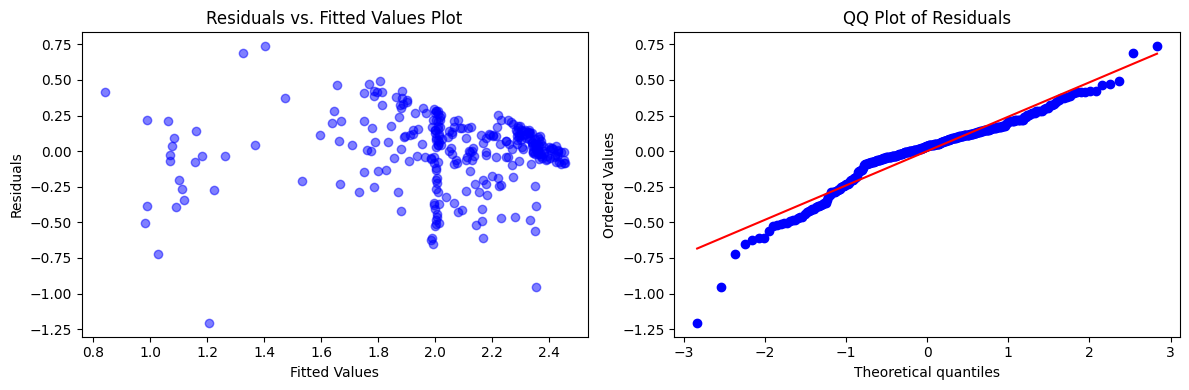

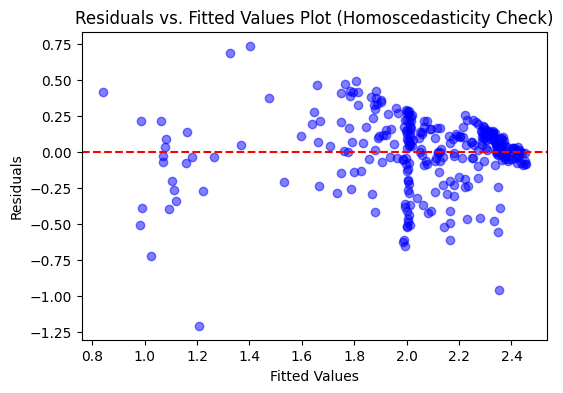

Durbin-Watson Statistic: 0.7728879144625811
                       Variable        VIF
0                         const  56.097388
1                midpoint_error   5.278574
2  previous_uncertainty_encoded   8.460347
3                   interaction   8.507203


In [14]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np


# Calculate the interaction term
data['interaction'] = data['midpoint_error'] * data['previous_uncertainty_encoded']

# Define the feature matrix (X) and target variable (y)
X = data[['midpoint_error', 'previous_uncertainty_encoded', 'interaction']]
X = sm.add_constant(X)  # Add a constant term for the intercept
y = data['log_trial']

# Create and train the linear regression model with statsmodels
model = sm.OLS(y, X).fit()

# Assumption 1: Linearity - Residuals vs. Fitted Values Plot
residuals = model.resid
fitted_values = model.fittedvalues
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(fitted_values, residuals, color='blue', alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values Plot')

# Assumption 2: Normality of Residuals - QQ Plot
plt.subplot(1, 2, 2)
stats.probplot(residuals, plot=plt)
plt.title('QQ Plot of Residuals')

plt.tight_layout()
plt.show()

# Assumption 3: Homoscedasticity - Residuals vs. Fitted Values Plot
plt.figure(figsize=(6, 4))
plt.scatter(fitted_values, residuals, color='blue', alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values Plot (Homoscedasticity Check)')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Assumption 4: Independence of Residuals - Durbin-Watson Statistic
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(model.resid)
print(f'Durbin-Watson Statistic: {dw_stat}')

# Additional Assumption: No Multicollinearity - Variance Inflation Factor (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_df = pd.DataFrame({'Variable': X.columns, 'VIF': vif})
print(vif_df)

# You can also check for autocorrelation in residuals using autocorrelation plots.

# The model summary provides p-values for each coefficient, which can help assess the significance of predictors.

# You should also consider visualizing residuals over time if your data has a time component.

# Interpretation of assumption tests should be based on domain knowledge and context.


Ok residuals. 
Homoscedasticity shouldn't have fanning? It doesn't right? 
VIF is high... 